In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Config.data_path()/'atlas'
path.mkdir(exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/atlas')

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/atlas/test_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/test_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/models'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/sample_submission.csv'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train.csv')]

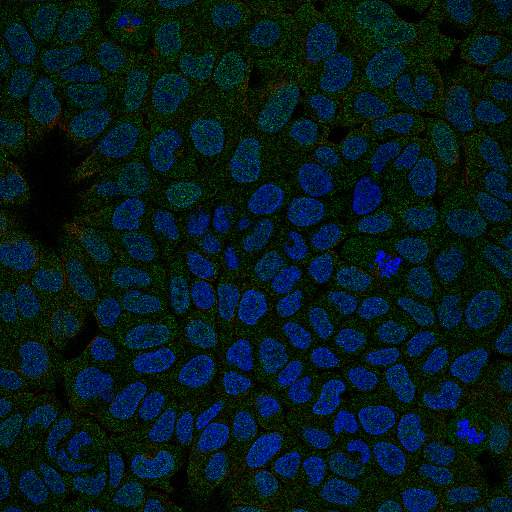

In [5]:
open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

In [6]:
df = pd.read_csv(path/'train.csv')

In [7]:
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
df.Id.nunique()

31072

In [9]:
df.loc[df['Id'] == '002679c2-bbb6-11e8-b2ba-ac1f6b6435d0']

,Id,Target
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0


In [10]:
sample_subm = pd.read_csv(path/'sample_submission.csv')

In [11]:
sample_subm.Id.nunique()

11702

In [12]:
sample_subm.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [13]:
# tere are no same test and train labels 
set(sample_subm.Id).intersection(df.Id)

set()

### Labels 

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

### Data Preparation

In [5]:
np.random.seed(42)

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
bs = 64

In [13]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train_combined', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ')
       .add_test_folder('test_combined'))

In [23]:
??ImageItemList.from_csv

In [19]:
??src.add_test

In [11]:
data = (src.transform(tfms, size=256)
        .databunch(bs=bs).normalize(imagenet_stats))

In [26]:
??MultiCategoryList

In [29]:
data.valid_ds.y

MultiCategoryList (6214 items)
[list(['4']) list(['25', '4']) list(['7']) list(['7', '5']) ... list(['2', '0']) list(['7']) list(['25'])
 list(['3', '0'])]
Path: .

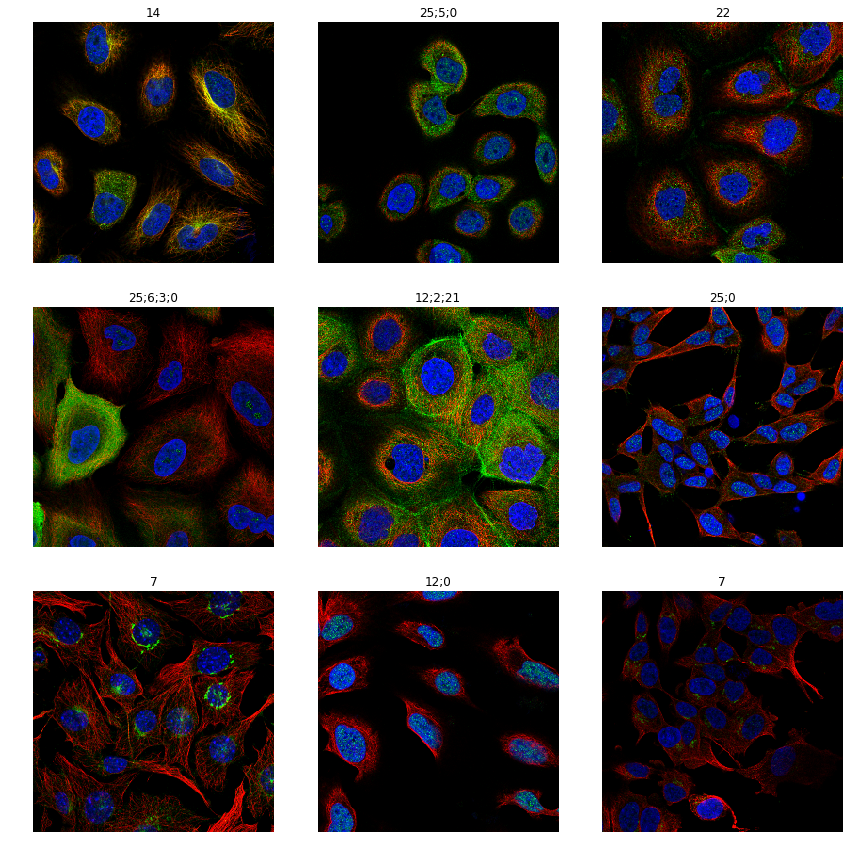

In [10]:
data.show_batch(rows=3, figsize=(12,12))

In [10]:
data.train_ds[0]

(Image (3, 256, 256), MultiCategory 16;0)

In [12]:
data.train_ds.y[0]

MultiCategory 16;0

In [13]:
data.train_ds.classes

['16',
 '0',
 '7',
 '1',
 '2',
 '5',
 '18',
 '23',
 '21',
 '24',
 '6',
 '25',
 '11',
 '3',
 '12',
 '13',
 '14',
 '4',
 '20',
 '22',
 '17',
 '19',
 '8',
 '9',
 '10',
 '26',
 '27',
 '15']

### Training

In [25]:
arch = models.resnet50

In [26]:
f1_score = partial(fbeta, thresh=0.2, beta=1.)
learn = create_cnn(data, arch, metrics=f1_score)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


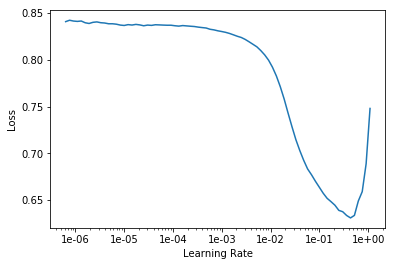

In [15]:
learn.recorder.plot()

In [16]:
lr = 3e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

Total time: 42:51
epoch  train_loss  valid_loss  fbeta   
1      0.134163    0.133924    0.537551  (08:46)
2      0.134699    0.134082    0.545650  (08:32)
3      0.122815    0.120466    0.583771  (08:31)
4      0.109274    0.109700    0.638816  (08:31)
5      0.103173    0.109834    0.658018  (08:29)



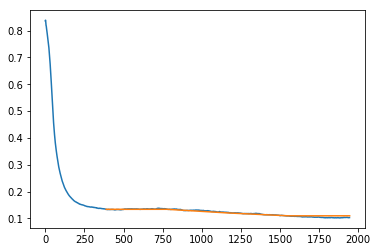

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('stage-1-rn50-256')

In [28]:
learn.load('stage-1-rn50-256')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[list(['16', '0']) list(['7', '1', '2', '0']) list(['5']) list(['1']) ... list(['21']) list(['5'])
 list(['25', '2', '21']) list(['2', '0'])]
Path: .
x: ImageItemList (24858 items)
['/home/ubuntu/.fastai/data/atlas/train_combined/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.png' ...
 '/home/ubuntu/.fastai/data/atlas/train_combined/ffed4430-bbac-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fff0a998-bbae-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0.png']
Path:

In [18]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


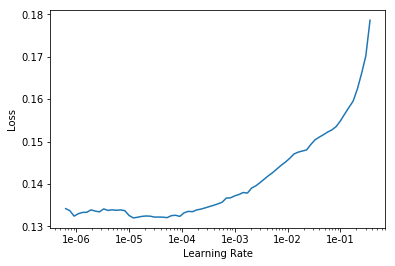

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 25:00
epoch  train_loss  valid_loss  fbeta   
1      0.134396    0.141376    0.512772  (05:14)
2      0.134099    0.131719    0.520215  (05:10)
3      0.133625    0.136998    0.523446  (05:10)
4      0.131856    0.144436    0.524693  (05:05)
5      0.131709    0.130413    0.524705  (04:18)



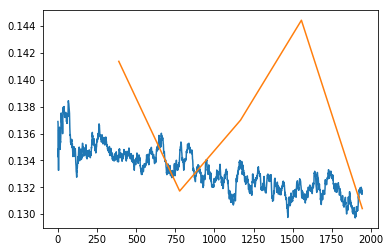

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-2-rn50-128')

In [27]:
learn.load('stage-2-rn50-128')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/.fastai/data/atlas/models/stage-2-rn50-128.pth'

#### Go bigger - 512 

In [23]:
bs = 32
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


In [24]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [25]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


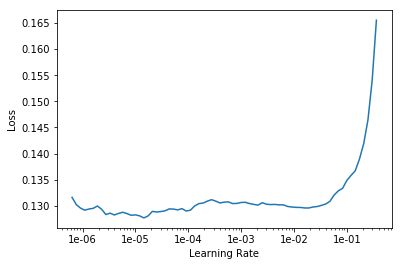

In [26]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr=1e-2/2

In [28]:
learn.fit_one_cycle(5, slice(lr))

Total time: 42:42
epoch  train_loss  valid_loss  fbeta   
1      0.122437    0.119449    0.580379  (08:39)
2      0.119869    0.119335    0.584345  (08:29)
3      0.115851    0.112412    0.612515  (08:31)
4      0.111456    0.118184    0.626147  (08:30)
5      0.109169    0.121722    0.631649  (08:30)



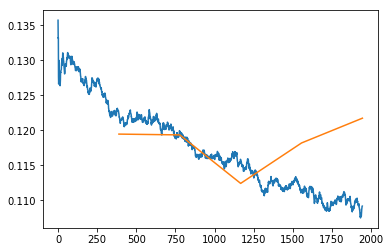

In [30]:
learn.recorder.plot_losses()

In [29]:
learn.save('stage-1-256-rn50')

In [21]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[list(['16', '0']) list(['7', '1', '2', '0']) list(['5']) list(['1']) ... list(['21']) list(['5'])
 list(['25', '2', '21']) list(['2', '0'])]
Path: .
x: ImageItemList (24858 items)
['/home/ubuntu/.fastai/data/atlas/train_combined/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.png' ...
 '/home/ubuntu/.fastai/data/atlas/train_combined/ffed4430-bbac-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fff0a998-bbae-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0.png']
Path:

In [22]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 58:07
epoch  train_loss  valid_loss  fbeta   
1      0.116697    0.124087    0.594611  (11:48)
2      0.115386    0.279061    0.599209  (11:34)
3      0.109810    0.140760    0.635584  (11:34)
4      0.104547    0.195851    0.658059  (11:35)
5      0.102096    0.140991    0.658268  (11:35)



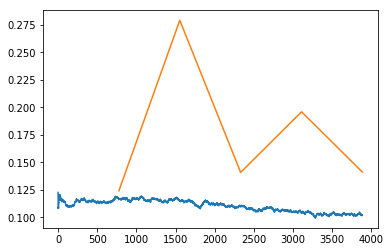

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2-256-rn50')

In [14]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[list(['16', '0']) list(['7', '1', '2', '0']) list(['5']) list(['1']) ... list(['21']) list(['5'])
 list(['25', '2', '21']) list(['2', '0'])]
Path: .
x: ImageItemList (24858 items)
['/home/ubuntu/.fastai/data/atlas/train_combined/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.png' ...
 '/home/ubuntu/.fastai/data/atlas/train_combined/ffed4430-bbac-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fff0a998-bbae-11e8-b2ba-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0.png'
 '/home/ubuntu/.fastai/data/atlas/train_combined/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0.png']
Path:

### Predict 

In [28]:
preds, target_values =  learn.get_preds(DatasetType.Valid)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [34]:
preds, target_values =  learn.TTA(ds_type=DatasetType.Valid)

Total time: 07:14



In [29]:
from sklearn import metrics

In [35]:
metrics.f1_score(target_values, (preds > 0.2), average='macro')

0.4079248294141103

#### on test

In [20]:
learn.data = (src.add_test_folder('test_combined')
        .transform(tfms, size=256)
        .databunch(bs=bs).normalize(imagenet_stats))

In [31]:
learn.data.test_ds.y = None

In [23]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

KeyError: 'Traceback (most recent call last):\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py", line 354, in __getitem__\n    if self.item is None: x,y = self.x[idxs],self.y[idxs]\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py", line 79, in __getitem__\n    if isinstance(try_int(idxs), int): return self.get(idxs)\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py", line 229, in get\n    return self._item_cls.create(o, self.class2idx)\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/core.py", line 165, in create\n    res = array([c2i[it] for it in o])\n  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/core.py", line 165, in <listcomp>\n    res = array([c2i[it] for it in o])\nKeyError: \';\'\n'

In [32]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

TypeError: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py", line 354, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
TypeError: 'NoneType' object is not subscriptable


In [43]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]

In [44]:
test_ids = get_image_names(learn.data)

In [45]:
# sanity check
set(test_ids).difference(sample_subm.Id.unique())

set()

In [46]:
def get_tags(predictions, data):
    return [" ".join(data.test_ds.ds.classes[i] for i,el in enumerate(predictions[j] > 0.2) if el==1)
            for j in range(len(predictions))]

In [47]:
tags = get_tags(preds, learn.data)

In [48]:
tags[:10]

['0', '2 5', '0 2 21 25', '0 2', '0', '23', '6 25', '0 1', '0 23 25', '0 25']

In [49]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})

In [50]:
submit_df.shape

(11702, 2)

In [51]:
submit_df.head()

,Id,Predicted
0,54332072-bacd-11e8-b2b8-ac1f6b6435d0,0
1,852a3012-bad7-11e8-b2b9-ac1f6b6435d0,2 5
2,19bc4e2e-bad1-11e8-b2b8-ac1f6b6435d0,0 2 21 25
3,1f538b56-bad9-11e8-b2b9-ac1f6b6435d0,0 2
4,cea42bf0-bacb-11e8-b2b8-ac1f6b6435d0,0


In [52]:
all(submit_df.Id.sort_values().values == sample_subm.Id.values)

True

In [53]:
submit_df.sort_values(by='Id', inplace=True)

In [54]:
all(submit_df.Id.values == sample_subm.Id.values)

True

In [55]:
os.makedirs('data/submits', exist_ok=True)

In [56]:
submit_df.to_csv('data/submits/p3-1-2-rn-34-128-256.csv', header=True, index=False)

In [60]:
! kaggle competitions submit -c human-protein-atlas-image-classification -f data/submits/p3-1-2-rn-34-128-256.csv -m ""

100%|█████████████████████████████████████████| 483k/483k [00:01<00:00, 302kB/s]
Successfully submitted to Human Protein Atlas Image Classification

#### Some sanity check after merging two test directorires

In [41]:
subm_df = pd.read_csv(path/'sample_submission.csv')

In [42]:
subm_df.shape

(11702, 2)

In [43]:
subm_df.Id.nunique()

11702

In [44]:
sub_test_set = set(subm_df.Id)

In [45]:
test_glob = (path/'test_combined').glob('*.*png')

In [46]:
path_test_set = set(f.stem for f in test_glob if f.is_file())

In [47]:
path_test_set.difference(sub_test_set)

set()